In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

C:\Users\v-sha\anaconda3\envs\my-env\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


# Начало работы с датасетом
- Посмотрим на данные
- Разделим весь врменной ряд на две непересекающиеся части

In [2]:
df = pd.read_csv('Microsoft_Stock.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012


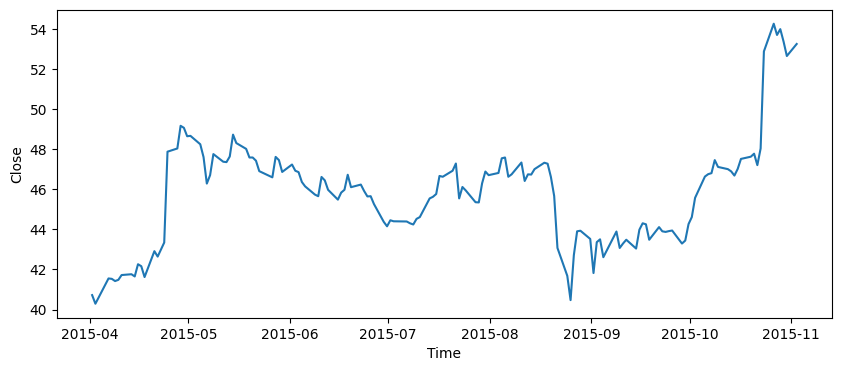

In [4]:
col = 'Close'
plt.figure(figsize=(10, 4))
plt.plot('Date', col, data=df.head(150))
plt.xlabel('Time')
plt.ylabel(col)
plt.show()

In [5]:
ts = df[[col]]
# ts.loc[:, 'Date'] = ts['Date'].dt.date
ts_dates = df['Date'].dt.date
ts.reset_index(inplace=True)
ts = ts.rename(columns={'index': 't', col: 'y'})
ts.head(10)

,t,y
0,0,40.72
1,1,40.29
2,2,41.55
3,3,41.53
4,4,41.42
5,5,41.48
6,6,41.72
7,7,41.76
8,8,41.65
9,9,42.26


In [6]:
n = ts.shape[0]
part = 0.8
train, test = ts.iloc[:int(n * part)], ts.iloc[int(n * part):]
print(f'Train: {len(train)}, test: {len(test)}')

Train: 1208, test: 303


# Простейшая линейная модель

- Выделим по x_n предыдущих значений и момент времени в качестве предикторов и y_n последующих значений в качестве временного ряда, который мы будем прогнозировать, это будут отрезки по времени в train и test
- Обучим линейную модель, посчитаем для каждого отрезка среднеквадратичное отклонение

In [7]:
data = [train, test].copy()
x_n, y_n = 10, 50

for j, d in enumerate(data):
    Y = {f'y_{i}': d['y'].shift(y_n - i) for i in range(1, y_n + 1)}
    X = {f'x_{i}': d['y'].shift(x_n + y_n - i) for i in range(1, x_n + 1)}
    data[j] = pd.DataFrame({'t': d['t']} | X | Y).dropna()

data[0]

,t,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50
59,59,40.72,40.29,41.55,41.53,41.42,41.48,41.72,41.76,41.65,...,45.97,45.48,45.83,45.97,46.72,46.10,46.23,45.91,45.64,45.65
60,60,40.29,41.55,41.53,41.42,41.48,41.72,41.76,41.65,42.26,...,45.48,45.83,45.97,46.72,46.10,46.23,45.91,45.64,45.65,45.26
61,61,41.55,41.53,41.42,41.48,41.72,41.76,41.65,42.26,42.16,...,45.83,45.97,46.72,46.10,46.23,45.91,45.64,45.65,45.26,44.37
62,62,41.53,41.42,41.48,41.72,41.76,41.65,42.26,42.16,41.62,...,45.97,46.72,46.10,46.23,45.91,45.64,45.65,45.26,44.37,44.15
63,63,41.42,41.48,41.72,41.76,41.65,42.26,42.16,41.62,42.91,...,46.72,46.10,46.23,45.91,45.64,45.65,45.26,44.37,44.15,44.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,1203,140.41,139.69,137.41,138.43,136.37,137.24,139.94,140.73,144.19,...,158.96,157.59,157.70,160.62,158.62,159.03,157.58,160.09,162.09,161.34
1204,1204,139.69,137.41,138.43,136.37,137.24,139.94,140.73,144.19,142.83,...,157.59,157.70,160.62,158.62,159.03,157.58,160.09,162.09,161.34,163.28
1205,1205,137.41,138.43,136.37,137.24,139.94,140.73,144.19,142.83,144.61,...,157.70,160.62,158.62,159.03,157.58,160.09,162.09,161.34,163.28,162.13
1206,1206,138.43,136.37,137.24,139.94,140.73,144.19,142.83,144.61,143.37,...,160.62,158.62,159.03,157.58,160.09,162.09,161.34,163.28,162.13,163.18


In [8]:
X_train, Y_train = data[0].iloc[:, :x_n + 1], data[0].iloc[:, x_n + 1:]
X_test, Y_test = data[1].iloc[:, :x_n + 1], data[1].iloc[:, x_n + 1:]

model = Ridge()
model.fit(X_train, Y_train)

Ridge()

In [9]:
Y_pred = pd.DataFrame(model.predict(X_test), columns=Y_test.columns)
Y_pred

,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,...,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49,y_50
0,170.248047,170.086173,169.448864,169.551071,169.389156,169.362914,168.900589,169.219761,169.095987,169.139669,...,171.114425,171.485196,171.569673,171.398304,171.151801,171.532052,171.594158,171.937743,171.975138,172.133229
1,173.638505,172.573162,172.808071,172.331756,171.935892,171.422976,171.950526,171.401547,171.554188,171.599692,...,173.864964,173.853698,173.621667,173.377482,173.852837,173.637181,173.936563,173.948912,174.239432,174.290621
2,178.166097,177.747190,177.521596,176.630314,175.567681,176.022746,175.716858,175.151284,175.371304,175.264126,...,177.726999,177.297797,176.984036,177.517905,177.393635,177.279384,177.252514,177.568329,177.825138,177.970232
3,179.266184,178.860521,178.026440,176.817727,177.125250,176.799744,176.253856,176.207506,176.152487,176.096650,...,178.168164,177.811357,178.285111,178.153418,178.061716,177.883919,178.243358,178.519359,178.635218,179.032033
4,182.600553,181.310080,180.233673,180.213038,179.489300,178.888583,179.104705,178.635095,178.693469,179.097769,...,180.335421,180.718324,180.526648,180.427801,180.368648,180.438106,180.644862,180.712007,181.270836,180.948544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,215.237254,215.374968,214.797894,215.901330,215.414105,215.326313,215.418315,215.582056,215.160431,214.962143,...,214.307343,215.006387,214.487541,214.539995,214.417664,215.008286,214.950105,214.921092,215.297522,215.255532
240,216.278185,215.557111,216.606271,216.043274,215.795629,215.858268,216.212620,215.786555,215.601166,215.350142,...,215.358562,214.906628,214.897491,214.673235,215.395062,215.231193,215.122219,215.367993,215.381817,215.737584
241,212.745287,214.121718,213.451151,213.452775,213.799399,214.194406,213.689091,213.875357,213.546736,213.067663,...,213.056946,213.135461,212.960465,213.663913,213.455703,213.558940,213.819244,213.821844,214.086380,214.458632
242,213.945713,213.233950,213.073516,213.449684,213.741662,213.208470,213.656627,213.576218,213.061331,213.082094,...,212.650533,212.641267,213.285510,212.902893,213.197048,213.428474,213.278645,213.311566,213.763751,213.885358


In [10]:
sq_err = np.linalg.norm(Y_test.values - Y_pred.values, axis=1) / y_n
print(f'Среднеквадратичная ошибка: {np.mean(sq_err):.2f}')
print(f'Относительная ошибка: {np.mean(sq_err) / ts['y'].mean():.2f}')

Среднеквадратичная ошибка: 2.05
Относительная ошибка: 0.02


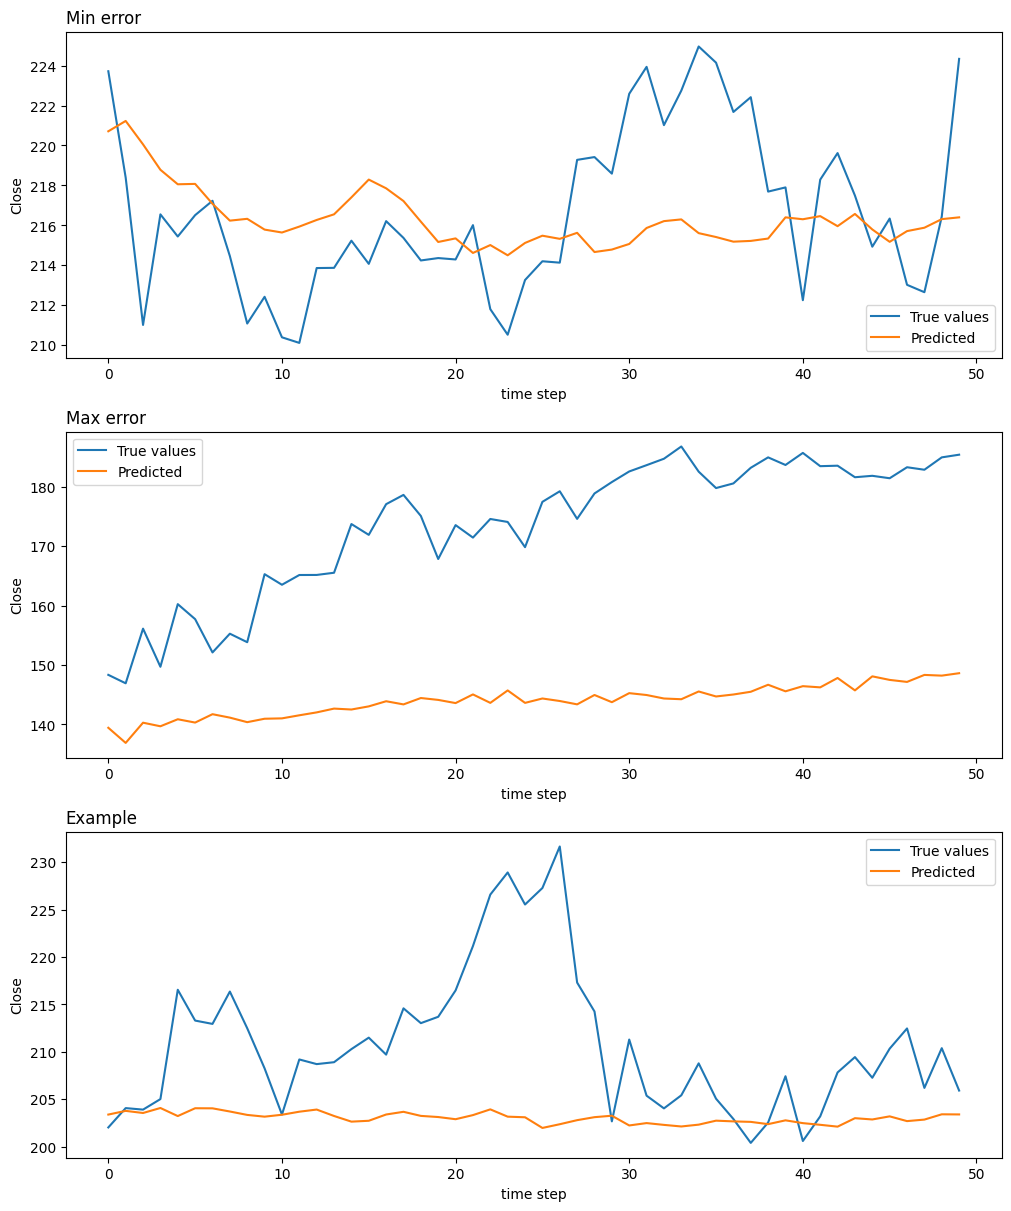

In [11]:
to_show = [np.argmin(sq_err), np.argmax(sq_err), len(sq_err) // 2]
titles = ['Min error', 'Max error', 'Example']

fig, axes = plt.subplots(3, 1, figsize=(10, 12), layout='constrained')
for ax, s, title in zip(axes, to_show, titles):
    ax.plot(Y_test.iloc[s].values, label='True values')
    ax.plot(Y_pred.iloc[s].values, label='Predicted')
    ax.set_xlabel('time step')
    ax.set_ylabel(col)
    ax.set_title(title, loc='left')
    ax.legend()

plt.show()

In [12]:
np.abs(Y_test.values.min() - Y_pred.values.min()), np.abs(Y_test.values.max() - Y_pred.values.max())

(np.float64(1.2179751607908145), np.float64(15.431324273944085))